<a href="https://colab.research.google.com/github/pergazuz/Leukemia-Classification-based-on-Microscopic-Images/blob/main/CPE352_Project_Model_MaxVIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data from kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/colab"

In [ ]:
#changing the working directory
%cd /content
#Check the present working directory using pwd command
!kaggle datasets download -d andrewmvd/leukemia-classification

In [ ]:
# !unzip /content/leukemia-classification.zip  && /content/leukemia-classification.zip

In [ ]:
!pip install torch transformers datasets evaluate pillow==9.2.0
!pip install git+https://github.com/rwightman/pytorch-image-models.git

In [5]:
import gc

gc.collect()
torch.cuda.empty_cache()

# Import lib

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split

import timm
import timm.optim
import timm.scheduler
from timm.data import ImageDataset, create_dataset, create_loader
from timm.data.transforms_factory import create_transform

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from PIL import Image

import evaluate

import numpy as np
import pandas as pd
from scipy import stats

from tqdm.notebook import tqdm

import glob

from sklearn.model_selection import KFold

from copy import copy

import shutil

2024-04-12 18:29:58.011283: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-12 18:29:59.746269: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data coverter

In [2]:
import os
from PIL import Image

def count_bmp_files(root_dir):
    """
    Count the number of BMP files within a directory tree.

    :param root_dir: Root directory to start counting.
    :return: Total number of BMP files.
    """
    count = 0
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.bmp'):
                count += 1
    return count

def convert_bmp_to_png(root_dir):
    """
    Convert all BMP files to PNG within a directory tree and display progress.

    :param root_dir: Root directory to start the conversion process.
    """
    total_files = count_bmp_files(root_dir)
    converted_count = 0

    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('.bmp'):
                bmp_path = os.path.join(subdir, file)
                png_path = bmp_path.replace('.bmp', '.png')

                # Open the BMP and save as PNG
                with Image.open(bmp_path) as img:
                    img.save(png_path)

                os.remove(bmp_path)

                converted_count += 1
                progress_percent = (converted_count / total_files) * 100
                print(f"Converted: {bmp_path} -> {png_path} [{progress_percent:.2f}% completed]")

# Usage
# convert_bmp_to_png('leukemia-classification/C-NMC_Leukemia/')

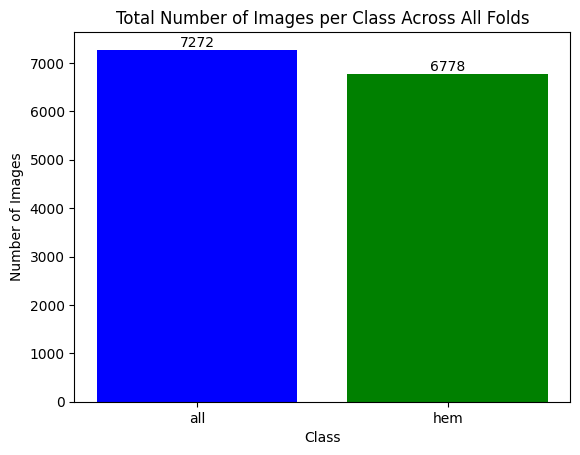

In [3]:
# Define the base directory for training data
base_dir = "leukemia-classification/C-NMC_Leukemia/training_data"

# Initialize a dictionary to hold the count of images in each class across all folds
# Now includes 'hem' to accumulate counts from 'hem' and 'augmented_hem'
class_counts = {'all': 0, 'hem': 0}

# Loop through each fold and add the counts to the class_counts dictionary
for fold in ['fold_0', 'fold_1', 'fold_2']:
    fold_path = os.path.join(base_dir, fold)
    # Loop through the classes, 'augmented_hem' counts are added to 'hem'
    for class_name in ['all', 'hem', 'augmented_hem']:
        class_path = os.path.join(fold_path, class_name)
        # Check if the class_path exists to accommodate for 'hem' and 'augmented_hem'
        if os.path.exists(class_path):
            num_images = len([name for name in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, name))])
            # 'augmented_hem' counts are added to 'hem'
            if class_name == 'augmented_hem':
                class_counts['hem'] += num_images
            else:
                class_counts[class_name] += num_images

# Plotting
fig, ax = plt.subplots()

# Set of different colors for the bars
colors = ['blue', 'green']

# Plot the counts for each class, removing 'augmented_hem' from the plot
ax.bar(class_counts.keys(), class_counts.values(), color=colors)

# Adding the count above each bar
for i, (class_name, count) in enumerate(class_counts.items()):
    ax.text(i, count, str(count), ha='center', va='bottom')

# Adding labels and title
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class Across All Folds')

# Show the plot
plt.show()

In [2]:
train_files = glob.glob("leukemia-classification/C-NMC_Leukemia/training_data/***/**/*.png")
test_files = glob.glob("leukemia-classification/C-NMC_Leukemia/testing_data/**/*.png")

In [40]:
import os
import shutil

def reorganize_dataset(source_dir, target_dir):
    """
    Reorganize the dataset from multiple fold-based class directories
    into a simplified class structure.

    Parameters:
        source_dir (str): The directory containing the original dataset with folds.
        target_dir (str): The directory where the reorganized dataset will be stored.
    """
    # Ensure the target directory exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)

    # Define the class directories in the target structure
    classes = ['all', 'hem']
    for cls in classes:
        os.makedirs(os.path.join(target_dir, cls), exist_ok=True)

    # Define the folds to process
    folds = ['fold_0', 'fold_1', 'fold_2']

    # Loop over each fold and move files
    for fold in folds:
        fold_path = os.path.join(source_dir, fold)
        
        # Process 'all' class
        all_class_path = os.path.join(fold_path, 'all')
        for filename in os.listdir(all_class_path):
            shutil.copy(os.path.join(all_class_path, filename), os.path.join(target_dir, 'all', filename))
        
        # Process 'hem' class
        hem_class_path = os.path.join(fold_path, 'hem')
        for filename in os.listdir(hem_class_path):
            shutil.copy(os.path.join(hem_class_path, filename), os.path.join(target_dir, 'hem', filename))
        
        # Process 'augmented_hem' class and move to 'hem'
        augmented_hem_class_path = os.path.join(fold_path, 'augmented_hem')
        for filename in os.listdir(augmented_hem_class_path):
            shutil.copy(os.path.join(augmented_hem_class_path, filename), os.path.join(target_dir, 'hem', filename))

    print("Dataset reorganization complete.")

# Define the source and target directory paths
source_dir = "leukemia-classification/C-NMC_Leukemia/training_data"
target_dir = "leukemia-classification/C-NMC_Leukemia/new_training_data"

# Run the reorganization function
# reorganize_dataset(source_dir, target_dir)

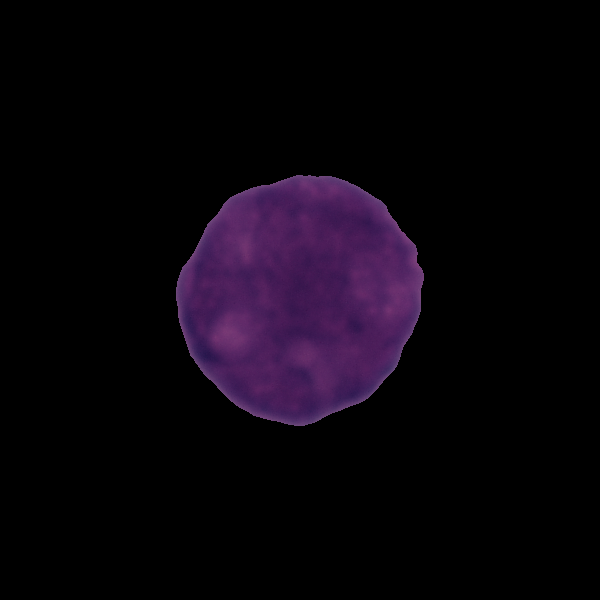

In [41]:
example = Image.open(test_files[1]).convert("RGB")
display(example)

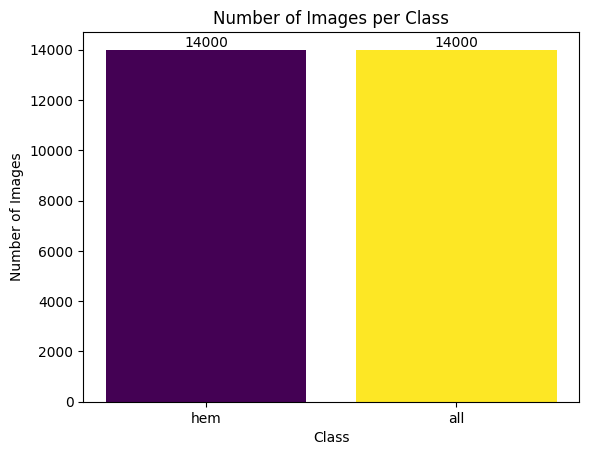

In [42]:
import os
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors  # Importing colors module
import numpy as np

# Path to the parent directory containing class directories
path = "leukemia-classification/C-NMC_Leukemia/new_training_data"

# Check if the path exists
if not os.path.exists(path):
    raise ValueError("The specified path does not exist")

# List all class directories
class_dirs = [d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))]

# Initialize a dictionary to count images per class
image_count = {}

# Iterate through each class directory and count image files
for class_dir in class_dirs:
    class_path = os.path.join(path, class_dir)
    # List all files in the class directory
    files = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    # Count the files (assuming all are images)
    image_count[class_dir] = len(files)

# Generate a color list from a colormap
color_list = plt.cm.viridis(np.linspace(0, 1, len(class_dirs)))

# Plotting with different colors for each bar
plt.bar(image_count.keys(), image_count.values(), color=color_list)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images per Class')

# Annotating each bar with the number of images
for i, (class_name, count) in enumerate(image_count.items()):
    plt.text(i, count, str(count), ha='center', va='bottom')

plt.show()

In [43]:
import cv2
import numpy as np
from skimage.restoration import denoise_wavelet
from PIL import Image
from torchvision.transforms import functional as F

class NoiseReduction(object):
    def __call__(self, img):
        img_array = np.array(img)
        img_denoised = denoise_wavelet(img_array, multichannel=True)
        img_denoised = Image.fromarray((img_denoised * 255).astype(np.uint8))
        return img_denoised

In [44]:
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

transforms = {
    "train": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        # T.Grayscale(num_output_channels=1),
        T.ToTensor()
    ]),
    "test": T.Compose([
        T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),
        # T.Grayscale(num_output_channels=1),
        T.ToTensor()
    ])
}

0


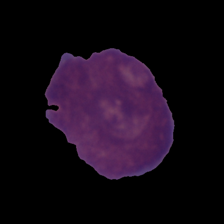

0


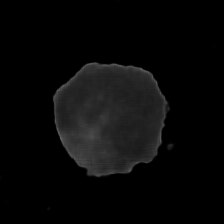

In [45]:
dataset = ImageFolder("leukemia-classification/C-NMC_Leukemia/new_training_data/", transform=transforms["train"])

# Function to show an image
def show_image(tensor):
    to_image = T.ToPILImage()  # Convert tensor to PIL Image"
    img = to_image(tensor)
    img.show()  # Display the image

# Get a sample from the dataset
img_tensor, label = dataset[70]

# Show the image
print(label)
show_image(img_tensor)


# Get a sample from the dataset
img_tensor, label = dataset[13000]

# Show the image
print(label)
show_image(img_tensor)

# Model Training

In [46]:
# List all available models
# timm.list_models("")

In [47]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [48]:
model_name = "timm/maxvit_tiny_tf_224.in1k"

In [58]:
criterion = nn.CrossEntropyLoss()

In [50]:
import torch
from torch.utils.data import DataLoader, random_split
import timm
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc

num_epochs = 6
train_batch_size = 32
eval_batch_size = 32
num_accumulate = 4

dataset_size = len(dataset)
train_size = int(dataset_size * 0.8)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=eval_batch_size, shuffle=False)

model = timm.create_model(model_name, pretrained=True, num_classes=2)
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = torch.nn.DataParallel(model)
model = model.to(device)

optimizer = timm.optim.create_optimizer_v2(model, opt="AdamW", lr=1e-3)
optimizer = timm.optim.Lookahead(optimizer, alpha=0.5, k=6)
scheduler = timm.scheduler.create_scheduler_v2(optimizer, num_epochs=num_epochs)[0]

train_losses = []
val_losses = []
auc_scores = []
precisions = []
recalls = []
f1_scores = []

for epoch in range(num_epochs):
    model.train()
    train_loss_epoch = []
    train_preds = []
    train_targets = []
    
    for idx, (inputs, targets) in enumerate(tqdm(train_dataloader)):
        
        outputs = model(inputs.to(device))
        loss = criterion(outputs, targets.to(device))
        loss.backward(retain_graph=True)
        
        if ((idx + 1) % num_accumulate == 0) or (idx + 1 == len(train_dataloader)):
            optimizer.step()
            scheduler.step_update(num_updates=epoch * len(train_dataloader))
            optimizer.zero_grad()

        train_loss_epoch.append(loss.item())
        train_preds.extend(outputs.argmax(dim=-1).detach().cpu().numpy())
        train_targets.extend(targets.cpu().numpy())

    optimizer.sync_lookahead()
    scheduler.step(epoch + 1)
    
    # Validation loop
    model.eval()
    val_loss_epoch = []
    val_targets = []
    val_scores = []
    
    with torch.no_grad():
        for inputs, targets in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss_epoch.append(loss.item())
            val_targets.extend(targets.cpu().numpy())
            val_scores.extend(outputs.softmax(dim=-1)[:, 1].cpu().numpy())


    train_losses.append(np.mean(train_loss_epoch))
    val_losses.append(np.mean(val_loss_epoch))
    
    precision, recall, _ = precision_recall_curve(val_targets, val_scores)
    pr_auc = auc(recall, precision)
    auc_scores.append(pr_auc)

    precision, recall, _ = precision_recall_curve(val_targets, val_scores)
    pr_auc = auc(recall, precision)

    # Store values from this epoch
    epoch_precisions.append(precision)
    epoch_recalls.append(recall)
    epoch_pr_aucs.append(pr_auc)

    # Calculate F1 Score, Precision, and Recall
    binary_preds = [1 if x >= 0.5 else 0 for x in val_scores]
    f1 = f1_score(val_targets, binary_preds)
    precision = precision_score(val_targets, binary_preds)
    recall = recall_score(val_targets, binary_preds)
    f1_scores.append(f1)
    precisions.append(precision)
    recalls.append(recall)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {np.mean(train_loss_epoch):.4f}, Val Loss: {np.mean(val_loss_epoch):.4f}, PR AUC: {pr_auc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

Let's use 2 GPUs!


 10%|███████▋                                                                   | 72/701 [01:27<12:45,  1.22s/it]


KeyboardInterrupt: 

In [ ]:
# Plotting the Precision-Recall curve
plt.figure(figsize=(10, 5))
plt.plot(epoch_recalls[-1], epoch_precisions[-1], label=f'Precision-Recall Curve (AUC = {epoch_pr_aucs[-1]:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.savefig("Precision_Recall_Curve.png")
plt.show()

# Plot training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig("Training_and_Validation_Loss.png")
plt.show()

In [ ]:
torch.save(model, f"maxvit_gans_6_epoch.pt")

In [32]:
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

class ImageDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the CSV file with annotations.
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        original_name = self.img_labels.iloc[idx]['new_names']
        # Change the file extension from .bmp to .png
        img_name = os.path.join(self.img_dir, original_name.replace('.bmp', '.png'))
        image = Image.open(img_name).convert('RGB')
        label = self.img_labels.iloc[idx]['labels']

        if self.transform:
            image = self.transform(image)

        return image, label

In [33]:
transform = T.Compose([
    T.Resize((224, 224), interpolation=T.InterpolationMode.BICUBIC),  # Resize to the input size expected by your model
    T.ToTensor(),
])

In [34]:
dataset_valid = ImageDataset(csv_file='leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv', img_dir='leukemia-classification/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data', transform=transform)

val_dataloader = DataLoader(dataset_valid, batch_size=1, shuffle=False)  # No need to batch if only one image

In [36]:
# model.eval()
# val_preds = []
# actual_labels = []

# with torch.no_grad():
#     for data, labels in tqdm(val_dataloader):
#         data = data.to(device)
#         outputs = model(data)
        
#         # Collect predictions using tolist() for direct list appending
#         val_preds += outputs.argmax(dim=-1).detach().cpu().tolist()
#         actual_labels.extend(labels.cpu().numpy())

# # Calculate and print metrics
# f1 = f1_score(actual_labels, val_preds, average='macro')
# roc_auc = roc_auc_score(actual_labels, val_preds, multi_class='ovr')
# precision = precision_score(actual_labels, val_preds, average='macro')
# recall = recall_score(actual_labels, val_preds, average='macro')

# print(f"F1 Score: {f1:.4f}")
# print(f"ROC AUC Score: {roc_auc:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall: {recall:.4f}")

100%|████████████████████████████████████████████████████████████████████████| 1867/1867 [03:46<00:00,  8.26it/s]

F1 Score: 0.1706
ROC AUC Score: 0.2032
Precision: 0.1838
Recall: 0.2032
